# Predicción incidencia del dengue Colombia Segundo Semestre 2012
## Demostración con fines investigativos y demostrativos


**Fuente y base modelamiento :** [Risk analysis for dengue suitability in Africa using the ArcGIS predictive analysis tools (PA tools)](https://www.sciencedirect.com/science/article/abs/pii/S0001706X16300808)

**Fuente de los datos dengue:** [Dengue HealthMap, Google, ProMED, HM Community News](https://healthmap.org/dengue/en/) y datos simulados en el interior del límite de Colombia donde presuntamente no hay casos de Dengue registrados para el año.

**Fuente Variables Climaticas:** [WorldClim](https://www.worldclim.org/)

**Corine Land Cover 2012:** [IDEAM 2012](http://www.ideam.gov.co/web/ecosistemas/coberturas-nacionales)

**Cuerpos de Agua:** Cartografía igac Escala 1:100.000


**Transformación de los datos software:** ArcGIS Pro


# Imports

In [1]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image, HTML
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import arcgis 
from arcgis.gis import GIS
from arcgis.raster import Raster
from arcgis.learn import MLModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

from fastai.vision import *

# Preparar datos de entrenamiento

## Layer
### Casos de Healthmap y simulaciones donde supuestamente no habia casos para el periodo

In [2]:
gis = GIS("https://www.arcgis.com",'user','password')

In [3]:
url = "https://services.arcgis.com/deQSb0Gn7gDPf3uV/arcgis/rest/services/DengueCol2012/FeatureServer/0"
LayerDengue = FeatureLayer(url)

![title](img/dengue_cases.PNG)

## Rasters

In [60]:
dem = Raster(r'images/dengue/dem.tif')
temp = Raster(r'images/dengue/annual_mean_temp.tif')
prec = Raster(r'images/dengue/annual_prec.tif')
clc = Raster(r'images/dengue/clc.tif')
water = Raster(r'images/dengue/dist_water.tif')

### DEM Elevación - WorldClim

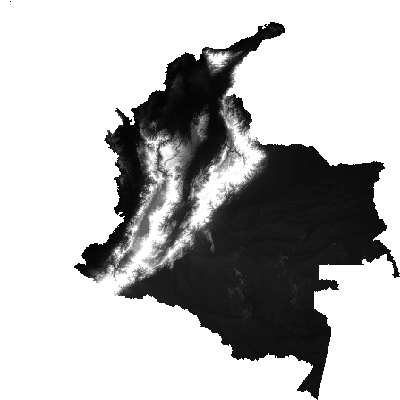

In [27]:
dem

### Temperatura Media Anual - WorldClim

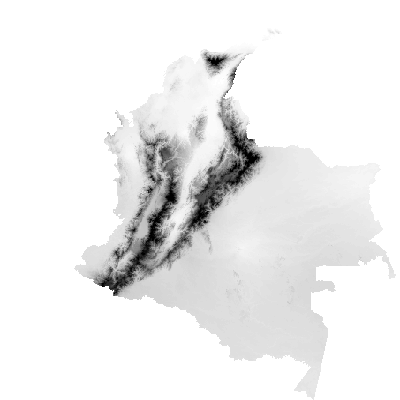

In [28]:
temp

### Precipitación Anual - WorldClim

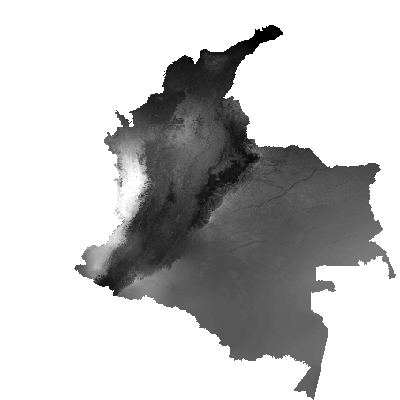

In [73]:
prec

### Distancia a cuerpos de agua, distancia euclidiana a Cuerpos de agua IGAC Escala 1:100.000

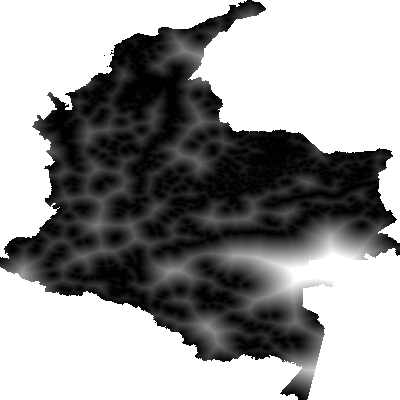

In [61]:
water

### Cobertura Corine Land Cover para Colombia IDEAM 2012

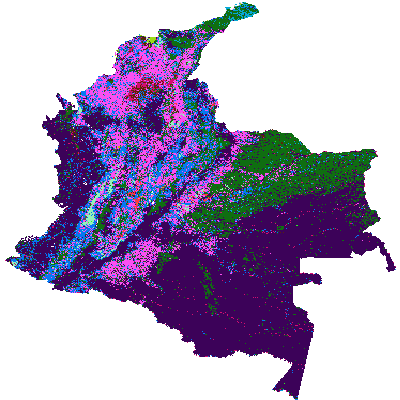

In [72]:
clc

## prepare_tabulardata

In [62]:
explanatory_rasters = [(clc,True),dem,temp,prec,water]#,dist_agua,dist_via]
# preprocessors = [('annual_mean_temp.tif','annual_prec.tif','dem.tif','dens.tif',MinMaxScaler())]
data = prepare_tabulardata(LayerDengue,variable_predict='Incidence',
                           explanatory_rasters=explanatory_rasters)#,preprocessors=preprocessors)

In [63]:
data.show_batch()

,Incidence,annual_mean_temp.tif,annual_prec.tif,clc.tif,dem.tif,dist_water.tif
4,1,27.312500,1803.0,24,372,0.141667
5,1,18.600000,2417.0,24,1715,0.150231
12,1,27.641666,1381.0,23,107,0.206155
61,0,5.012500,1241.0,32,3888,0.307431
84,0,25.829166,2632.0,31,474,0.123040


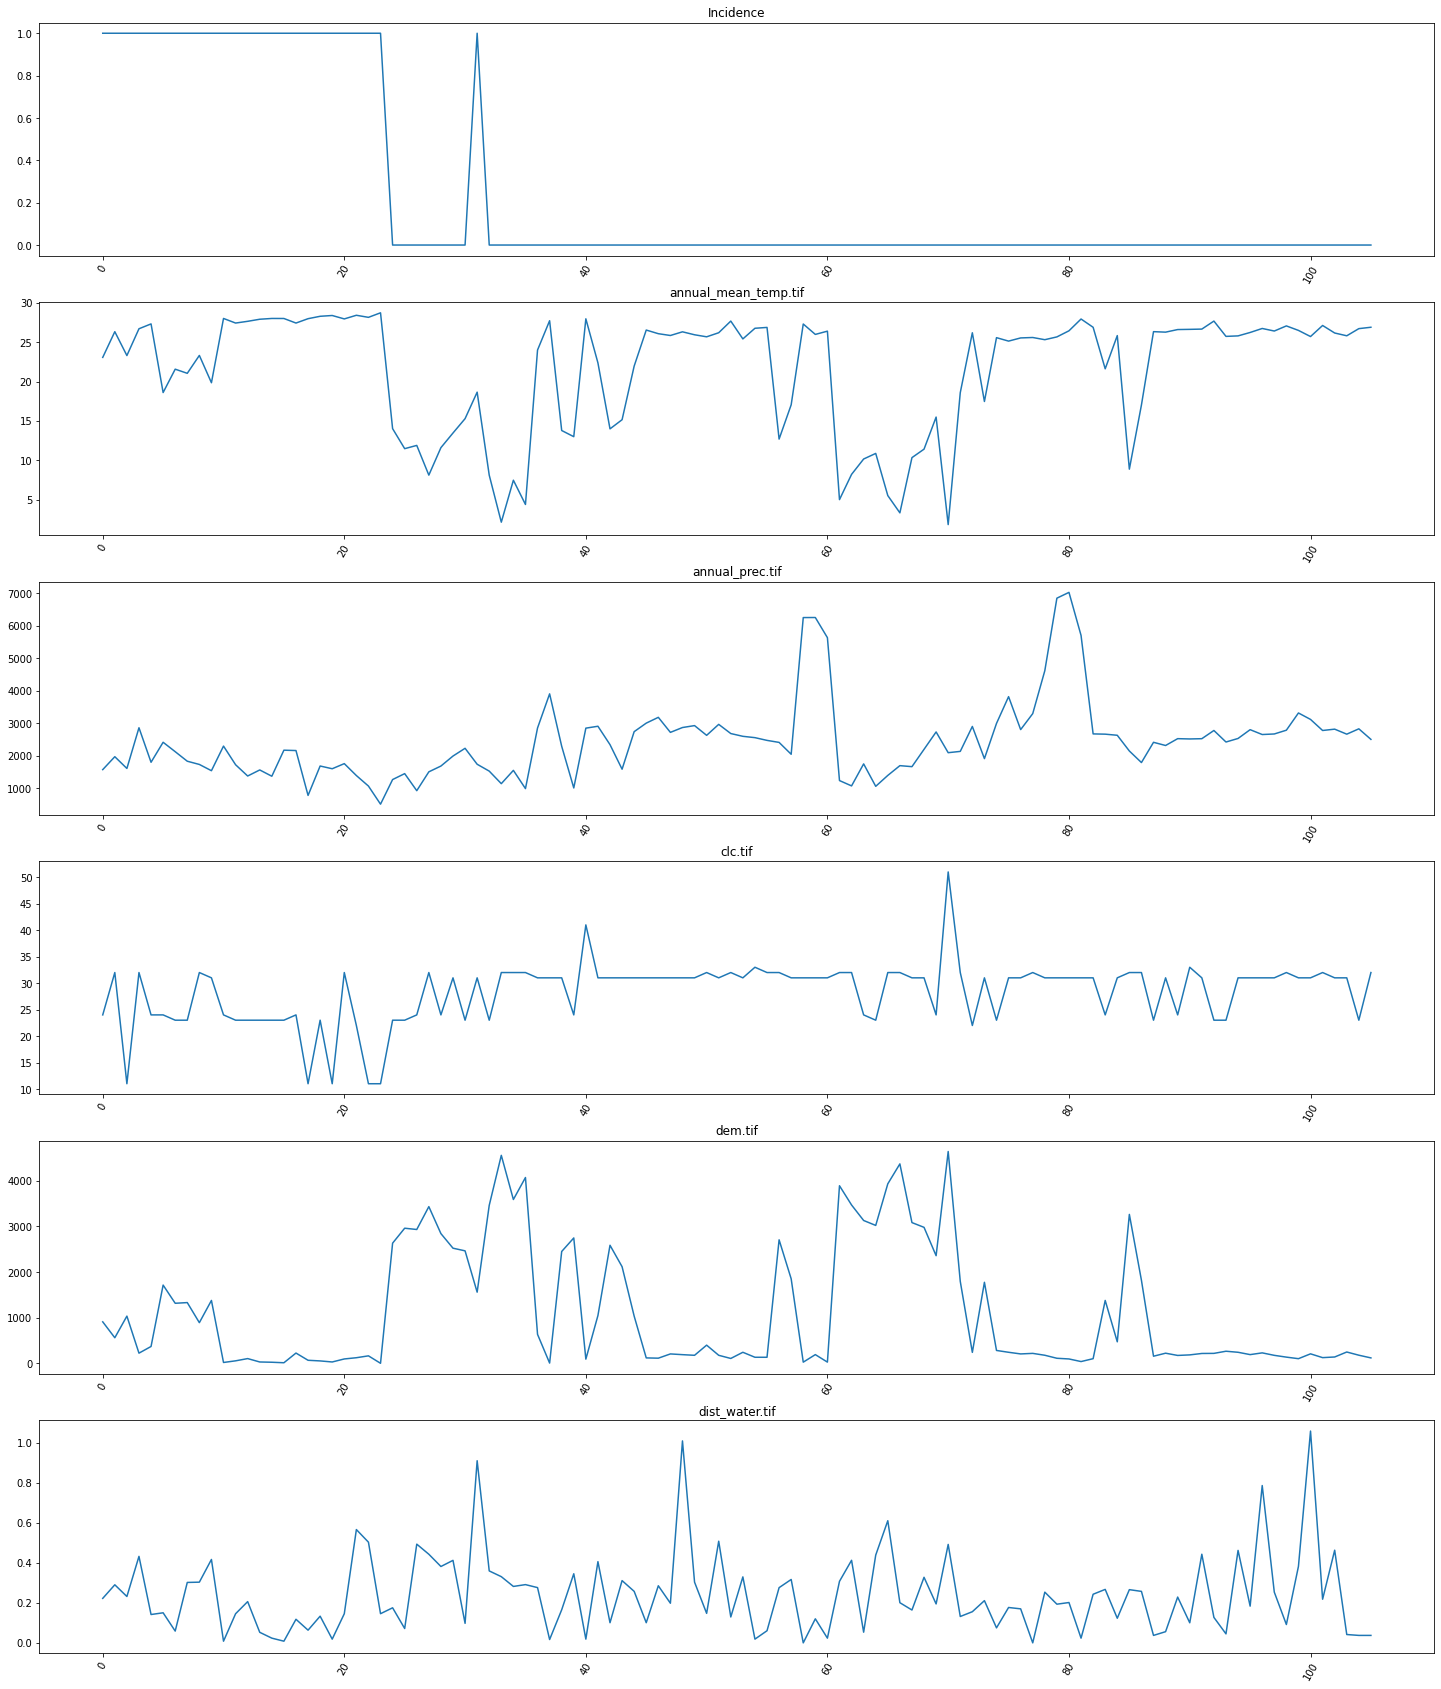

In [64]:
data._show_graph()

## Model

Classifier: [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboosting#sklearn.ensemble.GradientBoostingClassifier)

In [65]:
model = MLModel(data,model_type='sklearn.ensemble.GradientBoostingClassifier',n_estimators=100,random_state=123)

In [66]:
model.fit()

In [74]:
model.score()

0.8181818181818182

In [75]:
model.show_results()

,Incidence,annual_mean_temp.tif,annual_prec.tif,clc.tif,dem.tif,dist_water.tif,Incidence_results
13,1,27.904167,1567.0,23,33,0.052705,1
17,1,27.975000,785.0,11,70,0.063465,1
28,0,11.608334,1687.0,24,2841,0.381608,0
69,0,15.487500,2734.0,24,2358,0.194544,1
94,0,25.791666,2534.0,31,245,0.462031,0


In [70]:
predict_rasters = [clc,dem,temp,prec,water]

In [71]:
model.predict(explanatory_rasters=predict_rasters, 
              prediction_type='raster', 
              output_raster_path=r'images/dengue/predict_dengue.tif')

True

![title](img/dengue_predict.PNG)